In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.decomposition import PCA


In [3]:
df = pd.read_csv('../data/weatherAUS.csv')
print(df.shape)

(145460, 23)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [3]:
df['Location'].nunique()

49

In [4]:
df_sun = df.dropna(subset = 'Sunshine')
df_sun_concat = pd.concat([df['Location'].value_counts(), df_sun['Location'].value_counts()], axis = 1)
df_sun_concat.columns = ['Location_df', 'Location_df_sun']
df_sun_concat['ratio'] = (df_sun_concat['Location_df_sun'] / df_sun_concat['Location_df'])
df_sun_fin = df_sun_concat[df_sun_concat['ratio'] > 0.7]
df_sun_fin

list_location = df_sun_fin.index
list_location

# df_ev = df.dropna(subset = 'Evaporation')
# df_ev_concat = pd.concat([df['Location'].value_counts(), df_ev['Location'].value_counts()], axis = 1)
# df_ev_concat.columns = ['Location_df', 'Location_df_ev']
# df_ev_concat['ratio'] = (df_ev_concat['Location_df_ev'] / df_ev_concat['Location_df'])

# df_compare = pd.concat([df_ev_concat['ratio'], df_sun_concat['ratio']], axis = 1)
# df_compare.columns = ['ratio_ev', 'ratio_sun']
# df_compare = df_compare[(df_compare['ratio_ev'] > 0.7) & (df_compare['ratio_sun'] > 0.7)]
# df_compare

Index(['Sydney', 'Darwin', 'Hobart', 'Perth', 'Melbourne', 'Brisbane',
       'MountGambier', 'AliceSprings', 'Albany', 'Townsville', 'Cairns',
       'PerthAirport', 'SydneyAirport', 'NorfolkIsland', 'WaggaWagga',
       'Watsonia', 'Dartmoor', 'Portland', 'MelbourneAirport', 'Mildura',
       'Nuriootpa', 'PearceRAAF'],
      dtype='object', name='Location')

In [5]:
df['Sunshine'].nunique()

145

# sunshine en détail

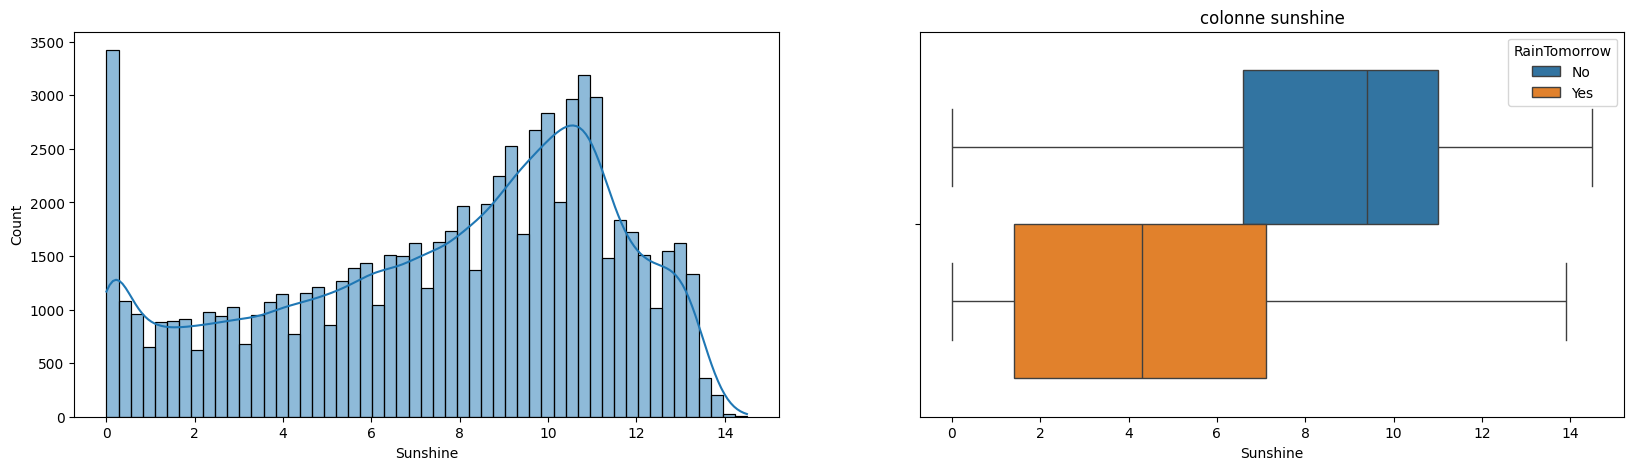

In [6]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
sns.histplot(data = df, x = df['Sunshine'].dropna(), kde = True)
plt.subplot(122)
sns.boxplot(data = df, x = df['Sunshine'].dropna(), hue = 'RainTomorrow')
plt.title('colonne sunshine')
plt.show()

<Axes: xlabel='Sunshine'>

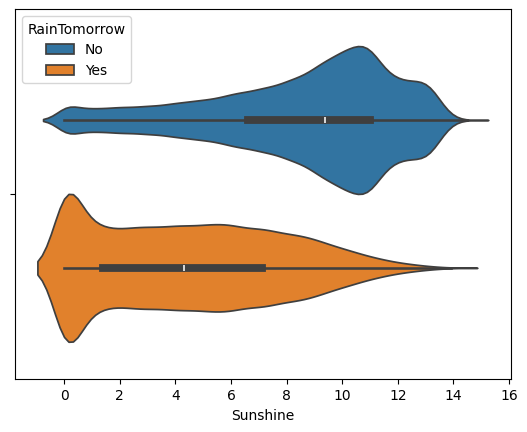

In [7]:
sns.violinplot(data = df, x = df['Sunshine'].dropna(), hue = 'RainTomorrow')


In [30]:
class sunshine_transformer(BaseEstimator, TransformerMixin):
    '''
    cette classe permet de gérer les colonnes vents quantitatives.
    elle prend en argument :
    geo : location, mais peut être changer par location,
    col_select : sunshine, colonne quantitative sur laquelle on veut remplacer les Nan,
    col_target : RainTomorrow
    method : median, peut être remplacer par mean, mod, etc
    '''


    def __init__(self, geo :str = 'Location', col_select : str = 'Sunshine', col_target : str = 'RainTomorrow', method : str = 'median'):
        self.dict_sun = {}
        self.geo = geo
        self.col_select = col_select
        self.col_target = col_target
        self.method = method

    def fit(self, X, y = None):
        # on récupère dans un dictionnaire la valeur de method pour la col_select dont on veut gérer les Nan, avec clé tuple(geo, col_target)

        X_drop = X.copy()
        X_drop = X_drop.dropna(subset = self.col_select)
        X_drop = pd.concat([X['Location'].value_counts(), X_drop['Location'].value_counts()], axis = 1)
        X_drop.columns = ['Location_df', 'Location_df_sun']
        X_drop['ratio'] = (X_drop['Location_df_sun'] / X_drop['Location_df'])
        X_drop = X_drop[X_drop['ratio'] > 0.7]

        for i in X_drop.index:
            for j in X[self.col_target].unique():
                self.dict_sun[i, j] = X[(X[self.geo] == i) & (X[self.col_target] == j)][self.col_select].agg(self.method)

        return self

    def transform(self, X):
        # on cherche le tuple(geo, col_target) et on applique la valeur de la method si c'est un Nan

        X[self.col_select] = X.apply(
                lambda row: self.dict_sun.get((row[self.geo], row[self.col_target]), row[self.col_select])
                if pd.isna(row[self.col_select]) else row[self.col_select],
                axis=1)

        return X

# Essai après prepocessing data

In [41]:
df = pd.read_csv('../data_saved/data_mat.csv')

df = df[df['Location'] == 'Sydney']
df.index = df['Date']

df.head()

,id_Location,id_Date,Date,Location,MinTemp,MaxTemp,Rainfall,Sunshine,WindGustSpeed,WindSpeed9am,...,Climate,Year,Month,Season,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-01,Sydney,2008-02-01,2008-02-01,Sydney,19.5,22.4,15.6,0.0,44.0,17.0,...,Temperate,2008,February,Summer,-0.92388,0.382683,-1.000000e+00,1.224647e-16,-9.238795e-01,-0.382683
2008-02-02,Sydney,2008-02-02,2008-02-02,Sydney,19.5,25.6,6.0,2.7,44.0,9.0,...,Temperate,2008,February,Summer,-0.92388,0.382683,-1.836970e-16,-1.000000e+00,6.123234e-17,1.000000
2008-02-03,Sydney,2008-02-03,2008-02-03,Sydney,21.6,24.5,6.6,0.1,44.0,17.0,...,Temperate,2008,February,Summer,-0.92388,0.382683,-3.826834e-01,9.238795e-01,-3.826834e-01,0.923880
2008-02-04,Sydney,2008-02-04,2008-02-04,Sydney,20.2,22.8,18.8,0.0,44.0,22.0,...,Temperate,2008,February,Summer,-0.92388,0.382683,9.238795e-01,3.826834e-01,6.123234e-17,1.000000
2008-02-05,Sydney,2008-02-05,2008-02-05,Sydney,19.7,25.7,77.4,0.0,44.0,11.0,...,Temperate,2008,February,Summer,-0.92388,0.382683,9.238795e-01,3.826834e-01,-1.836970e-16,-1.000000


In [42]:
df = df.drop(columns = ['id_Location', 'id_Date', 'Date', 'Location',
                        'Climate'])

df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'Year', 'Month', 'Season', 'WindGustDir_cos',
       'WindGustDir_sin', 'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos',
       'WindDir3pm_sin'],
      dtype='object')

In [30]:
dict_mois = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

df['Month'] = df['Month'].map(dict_mois)

df['sin_month'] = df['Month'].apply(lambda x : np.sin((2 * np.pi) * (( x - 1 ) / 12)))
df['cos_month'] = df['Month'].apply(lambda x : np.cos((2 * np.pi) * (( x - 1 ) / 12)))


df = df.drop(columns = 'Month')

In [31]:
dict_season = {
    'Spring' : 0,
    'Summer' : 1,
    'Autumn' : 2,
    'Winter' : 3
}

df['Season'] = df['Season'].map(dict_season)

df['sin_season'] = df['Season'].apply(lambda x : round(np.sin((2 * np.pi) * (x / 4))), 1)
df['cos_season'] = df['Season'].apply(lambda x : round(np.cos((2 * np.pi) * ( x / 4))), 1)

df = df.drop(columns = 'Season')

/tmp/ipykernel_186081/907855078.py:10: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['sin_season'] = df['Season'].apply(lambda x : round(np.sin((2 * np.pi) * (x / 4))), 1)
/tmp/ipykernel_186081/907855078.py:11: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['cos_season'] = df['Season'].apply(lambda x : round(np.cos((2 * np.pi) * ( x / 4))), 1)


In [32]:
X = df.drop(columns = 'RainTomorrow')
y = df['RainTomorrow']

In [33]:
y.value_counts()[0]/len(y)
y.value_counts()[1]/len(y)

np.float64(0.25921486364998503)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter = 1000,
                           verbose = 1,
                           class_weight = {0 : y.value_counts()[0]/len(y),
                                           1 : y.value_counts()[1]/len(y)})

model.fit(X_train_scaled, y_train)

print('score accuracy : ', model.score(X_test_scaled, y_test), end = '\n\n')

y_pred = model.predict(X_test_scaled)

print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score accuracy :  0.8473053892215568

f1 score :  0.6046511627906976
roc-auc score :  0.7183628189408536
[[488   7]
 [ 95  78]]
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       495
         1.0       0.92      0.45      0.60       173

    accuracy                           0.85       668
   macro avg       0.88      0.72      0.76       668
weighted avg       0.86      0.85      0.83       668



In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()

model.fit(X_train_scaled, y_train)

print('score accuracy : ', model.score(X_test_scaled, y_test), end = '\n\n')

y_pred = model.predict(X_test_scaled)

print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score accuracy :  0.8667664670658682

f1 score :  0.7343283582089553
roc-auc score :  0.8053135106000718
[[456  28]
 [ 61 123]]
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       484
         1.0       0.81      0.67      0.73       184

    accuracy                           0.87       668
   macro avg       0.85      0.81      0.82       668
weighted avg       0.86      0.87      0.86       668



In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

sample = SMOTE(random_state = 42)

X_train_s, y_train_s = sample.fit_resample(X_train, y_train)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight = {0 : y_train_s.value_counts()[0]/len(y_train_s),
                                           1 : y_train_s.value_counts()[1]/len(y_train_s)})

model.fit(X_train_scaled, y_train_s)

print('score accuracy : ', model.score(X_test_scaled, y_test), end = '\n\n')

y_pred = model.predict(X_test_scaled)

print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score accuracy :  0.8413173652694611

f1 score :  0.7253886010362695
roc-auc score :  0.8308869037192737
[[422  73]
 [ 33 140]]
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       495
         1.0       0.66      0.81      0.73       173

    accuracy                           0.84       668
   macro avg       0.79      0.83      0.81       668
weighted avg       0.86      0.84      0.85       668



In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

sample = RandomUnderSampler(random_state = 42)

X_train_s, y_train_s = sample.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight = {0 : y_train.value_counts()[0]/len(y),
                                           1 : y_train.value_counts()[1]/len(y)})

model.fit(X_train_scaled, y_train_s)

print('score accuracy : ', model.score(X_test_scaled, y_test), end = '\n\n')

y_pred = model.predict(X_test_scaled)

print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score accuracy :  0.8622754491017964

f1 score :  0.7228915662650602
roc-auc score :  0.7971613366870283
[[456  28]
 [ 64 120]]
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       484
         1.0       0.81      0.65      0.72       184

    accuracy                           0.86       668
   macro avg       0.84      0.80      0.82       668
weighted avg       0.86      0.86      0.86       668



In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)


sample = SMOTE(random_state = 42)

X_train_s, y_train_s = sample.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [924],
    'max_features': ['log2'],
    'criterion': ['log_loss'],
    'max_depth': [30],
    'bootstrap': [False],
    'min_samples_split': [7],
    'min_samples_leaf': [2],
}

model =RandomForestClassifier( n_jobs = -1,
                              n_estimators = 500,
                              class_weight = {0 : y.value_counts()[0]/len(y),
                                           1 : y.value_counts()[1]/len(y)})

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train_s)

print('best_estimator : ', grid_search.best_estimator_)
print('best_params :', grid_search.best_params_)

y_pred = grid_search.predict(X_test_scaled)

print('score accuracy :', grid_search.score(X_test_scaled, y_test))
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=924; total time=   5.9s
[CV] END bootstrap=False, criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=924; total time=   6.0s
[CV] END bootstrap=False, criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=924; total time=   6.0s
[CV] END bootstrap=False, criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=924; total time=   6.1s
[CV] END bootstrap=False, criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=924; total time=   6.1s
best_estimator :  RandomForestClassifier(bootstrap=False,
                       class_weight={0: np.float64(0.740785136350015),
                           

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# Application de SMOTE pour gérer le déséquilibre
sample = SMOTE(random_state=42)
X_train_s, y_train_s = sample.fit_resample(X_train, y_train)

# Mise à l'échelle des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test)

# Grille de recherche pour RandomForest
param_grid = {
    'n_estimators': [100, 110, 120],  # Essayez plusieurs valeurs
    'max_features': ['log2'],  # Essayez d'autres options
    'criterion': ['entropy'],  # Essayez de tester différents critères
    'max_depth': [21],  # Plage plus large pour la profondeur
    'bootstrap': [False],  # Tester les deux options pour bootstrap
    'min_samples_split': [2],  # Tester différentes valeurs
    'min_samples_leaf': [1],  # Tester plusieurs valeurs
}

# Modèle RandomForest sans `class_weight` car SMOTE est utilisé
model = RandomForestClassifier(n_jobs=-1)

# GridSearchCV pour ajuster les hyperparamètres
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2, cv=5)

# Entraînement du modèle
grid_search.fit(X_train_scaled, y_train_s)

# Meilleurs paramètres et modèle
print('Best Estimator:', grid_search.best_estimator_)
print('Best Parameters:', grid_search.best_params_)

# Prédictions sur l'ensemble de test
y_pred = grid_search.predict(X_test_scaled)

# Évaluation des performances
print('Accuracy score:', grid_search.score(X_test_scaled, y_test))
print('F1 score:', f1_score(y_test, y_pred))
print('ROC AUC score:', roc_auc_score(y_test, y_pred))

# Matrice de confusion et rapport de classification
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=   1.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=   1.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=21, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=   1.4s
[CV]